<a href="https://colab.research.google.com/github/owl-d/Basic_DeepLearning/blob/main/Doit_Ch05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***05-1 검증 세트(Validation Set) 나누고 전처리***

In [1]:
#로지스틱 회귀로 모델 훈련하고 평가하기
#4장에서와 같이 cancer 데이터 세트 읽어 들여 훈련 세트와 테스트 세트로 나눈다.

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target

x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [2]:
#훈련 및 평가

from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss = 'log', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

In [3]:
#SVM(서포트 벡터 머신)으로 모델 훈련하고 평가하기

from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss = 'hinge', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

validation set 이용 (여기서는 검증 세트로 간단히 훈련만 : 실제 튜닝은 나중에)

In [4]:
#1. 데이터 세트 준비
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [5]:
#2. 검증 세트 분할
#위 1번 과정에서 전체 데이터 세트를 8:2의 비율로 훈련 세트와 검증 세트로 만들었으므로
#여기서는 다시 훈련 세트를 8:2로 나누어 훈련 세트와 검증 세트를 만든다.

x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train), len(x_val))

364 91


In [6]:
#3. 검증 세트 사용해 모델 평가
# 훈련 세트의 크기가 줄어 score도 낮아짐

sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

0.6923076923076923

**데이터 전처리와 특성의 스케일**

-데이터 전처리(data preprocessing) : 날것의 데이터를 그대로 사용하면 누락되거나 데이터 형태가 비균일

-특성의 스케일(scale) : 잘 정리된 데이터도 특성의 스케일(값의 범위)이 다르면 스케일 조정하는 전처리 필요. 특히 경사하강법은 스케일에 민감한 알고리즘이다.

먼저, 스케일 조정하지 않고 모델 훈련

['mean perimeter' 'mean area']


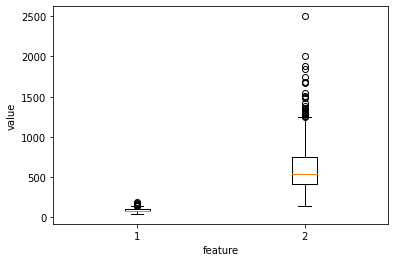

In [7]:
#스케일 조정하지 않고 모델 훈련
#1. 훈련 데이터 준비 및 스케일 비교

import matplotlib.pyplot as plt

print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [8]:
#2. 가중치 기록 및 학습률 조절
#SingleLayer 클래스에 인스턴스 변수 추가해 epoch마다 가중치 값 저장해 가중치 변화 관찰할 때 사용
#learning rate(학습률) 조절

import numpy as np

class SingleLayer:

  def __init__(self, learning_rate=0.1): #학습률 지정
    self.w = None
    self.b = None
    self.losses = []
    self.w_history = [] #가중치 값 저장
    self.lr = learning_rate #학습률

  def forpass(self, x): #정방향 계산
    z = np.sum(x*self.w) + self.b #가중합 구하기 위해 np.sum 사용
    return z

  def backprop(self, x, err): #역방향 계산
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def activation(self, z):  #활성화 함수 메서드
    z = np.clip(z, -100, None)
    a = 1 / (1 + np.exp(-z))  #시그모이드 계산
    return a

  def fit(self, x, y, epochs=100):
    self.w = np.ones(x.shape[1]) #가중치 개수를 x에 맞춰 1로 초기화
    self.b = 0
    self.w_history.append(self.w.copy()) ## 가중치 기록
    np.random.seed(42)                   ## 무작위로 시드 지정
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) #index 섞기
      for i in indexes:
        z = self.forpass(x[i])   #정방향 계산
        a = self.activation(z)  #활성화 함수 적용
        err = -(y[i] - a)        #오차 계산
        w_grad, b_grad = self.backprop(x[i], err)  #역방향 계산
        self.w -= self.lr * w_grad        #가중치 업데이트
        self.b -= b_grad        #절편 업데이트
        self.w_history.append(self.w.copy())  ##가중치 업데이트
        a = np.clip(a, 1e-10, 1-1e-10)  #안전한 로그 계산 위해 클리핑 한 후 손실 누적
        loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))

      self.losses.append(loss/len(y)) #각 에폭마다 평균 손실 저장

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x]  #정방향 계산
    return np.array(z) > 0                #계단 함수 적용(sigmoid 함수 적용하지 않아도 z의 값으로 알 수 있음)

  def score(self, x, y):  #모델의 정확도
    return np.mean(self.predict(x)==y)

In [9]:
#3. 모델 훈련하고 평가하기
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

0.9120879120879121

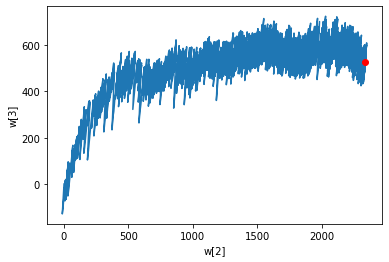

In [10]:
w2 = []
w3 = []
for w in layer1.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

#mean perimeter(w[2])에 비해 mean area(w[3])의 스케일이 커
#w3의 값이 학습 과정에서 큰 폭으로 흔들리며 변화
#반면 w2의 값은 0부터 시작해 조금씩 최적값에 가까워진다.

#w3에 대한 gradient가 크기 때문에 w3 축을 따라 차중치가 크게 요동치고 있다.

스케일 조정해 모델 훈련 : 표준화(standardization) : 평균 0, 분산 1

In [11]:
#1. 넘파이로 표준화 구현하기

train_mean = np.mean(x_train, axis=0) #평균
train_std = np.std(x_train, axis=0)   #표준편차=분산의 제곱근
x_train_scaled = (x_train - train_mean) / train_std #표준화: (입력값-평균)/표준편차

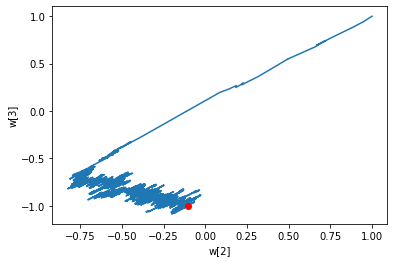

In [12]:
#2. 모델 훈련하기
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2 = []
w3 = []
for w in layer2.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

#w2, w3의 변화 비율이 비슷하기 때문에 대각선 방향으로 가중치 이동
#두 특성의 스케일을 비슷하게 맞추었으므로 최적값에 빠르게 근접

In [13]:
#3. 모델 성능 평가
#검증 세트에서 모델 성능 평가 : 검증 세트의 스케일을 바꾸지 않았기 때문에 성능 구림
layer2.score(x_val, y_val)

0.37362637362637363

In [14]:
#검증 세트도 표준화 전처리 적용

val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean) / val_std
layer2.score(x_val_scaled, y_val)

0.967032967032967

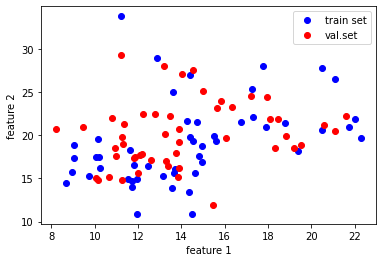

In [15]:
#스케일 조정 후 실수하기 쉬운 함정
#훈련 세트와 검증세트가 다른 비율로 스케일이 조정된 경우!
#미세하지만 훈련 세트와 검중 세트가 다른 비율로 변환(가로축과 세로축)

#1. 비교 위해서, 원본 훈련 세트와 검증 세트로 산점도 그리기
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')
plt.plot(x_val[:50, 0], x_val[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val.set'])
plt.show()

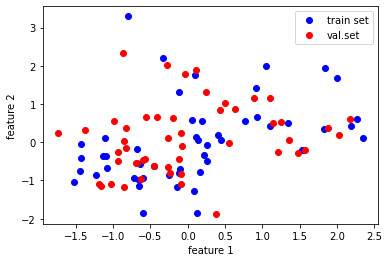

In [16]:
#2. 전처리한 훈련 세트와 검증 세트로 산점도 그리기
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val.set'])
plt.show()

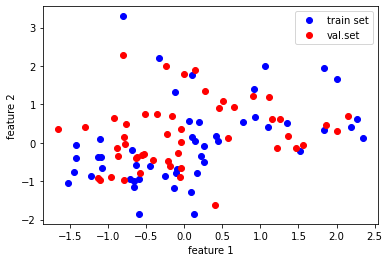

In [17]:
#3. 올바르게 검증 세트 전처리하기
#검증 세트를 훈련 세트의 평균, 표준 편차 이용해 검증 세트 변환

x_val_scaled = (x_val - train_mean) / train_std
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val.set'])
plt.show()

#원본 데이터의 산점도와 스케일 조정 이후 산점도가 같다. 검증 세트와 훈련 세트가 동일한 비율로 변환되었다!

In [18]:
#4. 모델 평가
#검증 세트로 모델 성능 평가
layer2.score(x_val_scaled, y_val)

0.967032967032967

***05-2 과대적합과 과소적함***

In [19]:
#적절한 편향-분산 트레이드오프(bias-variance tradeoff)를 선택해야한다.
#과소적합된 모델은 '편향되었다'고 하고 과대적합된 모델은 '분산이 크다'라고 한다.

#1. 검증 손실 기록 및 손실 계산 함수 추가

import numpy as np
import matplotlib.pyplot as plt

class SingleLayer:

  def __init__(self, learning_rate=0.1): #학습률 지정
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = [] ##검증 세트에 대한 손실 기록
    self.w_history = [] #가중치 값 저장
    self.lr = learning_rate #학습률

  def forpass(self, x): #정방향 계산
    z = np.sum(x*self.w) + self.b #가중합 구하기 위해 np.sum 사용
    return z

  def backprop(self, x, err): #역방향 계산
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def activation(self, z):  #활성화 함수 메서드
    z = np.clip(z, -100, None)
    a = 1 / (1 + np.exp(-z))  #시그모이드 계산
    return a

  def fit(self, x, y, epochs=100, x_val=None, y_val=None): ##검증 세트 전달받을 수 있도록 매개변수 추가
    self.w = np.ones(x.shape[1]) #가중치 개수를 x에 맞춰 1로 초기화
    self.b = 0
    self.w_history.append(self.w.copy()) # 가중치 기록
    np.random.seed(42)                   # 무작위로 시드 지정
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) #index 섞기
      for i in indexes:
        z = self.forpass(x[i])   #정방향 계산
        a = self.activation(z)  #활성화 함수 적용
        err = -(y[i] - a)        #오차 계산
        w_grad, b_grad = self.backprop(x[i], err)  #역방향 계산
        self.w -= self.lr * w_grad        #가중치 업데이트
        self.b -= self.lr * b_grad        #절편 업데이트
        self.w_history.append(self.w.copy())  #가중치 업데이트
        a = np.clip(a, 1e-10, 1-1e-10)  #안전한 로그 계산 위해 클리핑 한 후 손실 누적
        loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))

      self.losses.append(loss/len(y)) #각 에폭마다 평균 손실 저장
      self.update_val_loss(x_val, y_val) ##검증 세트에 대한 손실 계산

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x]  #정방향 계산
    return np.array(z) > 0                #계단 함수 적용(sigmoid 함수 적용하지 않아도 z의 값으로 알 수 있음)

  def score(self, x, y):  #모델의 정확도
    return np.mean(self.predict(x)==y)

  def update_val_loss(self, x_val, y_val): #검증 세트 손실 계산
    if x_val is None:
      return
    val_loss=0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i]) #정방향 계산
      a = self.activation(z)     #활성화 함수 적용
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a)) #로지스틱 손실 함수의 값 계산
    self.val_losses.append(val_loss/len(y_val)) #계산한 손실 함수 값 추가

In [20]:
#2. 모델 훈련
#표준화(전처리)된 훈련 세트와 검증 세트 이용해 단일층 신경망 훈련

layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

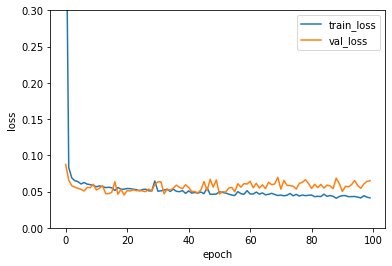

In [21]:
#3. 손실값으로 그래프 그려 epoch 횟수 지정

plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

#검증 손실이 대략 20번째 epoch 이후 훈련 세트보다 높아진다.
#이 모델은 20번의 epoch 이후에는 훈련할 필요 없다.

In [22]:
#4. 훈련 조기 종료(early stopping)
#20번의 epoch까지 모델 훈련한 다음 검증 세트의 성능 확인해보기

layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20)
layer4.score(x_val_scaled, y_val)

0.989010989010989

***05-3 로지스틱 회귀에 규제 적용***

In [23]:
import numpy as np
import matplotlib.pyplot as plt

class SingleLayer:

  def __init__(self, learning_rate=0.1, l1=0, l2=0): #학습률 지정
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = [] #검증 세트에 대한 손실 기록
    self.w_history = [] #가중치 값 저장
    self.lr = learning_rate #학습률
    self.l1 = l1  ##L1 규제 강도 조절
    self.l2 = l2  ##L2 규제 강도 조절

  def forpass(self, x): #정방향 계산
    z = np.sum(x*self.w) + self.b #가중합 구하기 위해 np.sum 사용
    return z

  def backprop(self, x, err): #역방향 계산
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def activation(self, z):  #활성화 함수 메서드
    z = np.clip(z, -100, None)
    a = 1 / (1 + np.exp(-z))  #시그모이드 계산
    return a

  def fit(self, x, y, epochs=100, x_val=None, y_val=None): ##검증 세트 전달받을 수 있도록 매개변수 추가
    self.w = np.ones(x.shape[1]) #가중치 개수를 x에 맞춰 1로 초기화
    self.b = 0
    self.w_history.append(self.w.copy()) # 가중치 기록
    np.random.seed(42)                   # 무작위로 시드 지정
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) #index 섞기
      for i in indexes:
        z = self.forpass(x[i])   #정방향 계산
        a = self.activation(z)  #활성화 함수 적용
        err = -(y[i] - a)        #오차 계산
        w_grad, b_grad = self.backprop(x[i], err)  #역방향 계산
        w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w ##L1규제와 L2규제 하나의 식으로 작성
        self.w -= self.lr * w_grad        #가중치 업데이트
        self.b -= self.lr * b_grad        #절편 업데이트
        self.w_history.append(self.w.copy())  #가중치 기록
        a = np.clip(a, 1e-10, 1-1e-10)  #안전한 로그 계산 위해 클리핑 한 후 손실 누적
        loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))

      self.losses.append(loss/len(y)) #각 에폭마다 평균 손실 저장
      self.update_val_loss(x_val, y_val) ##검증 세트에 대한 손실 계산

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x]  #정방향 계산
    return np.array(z) > 0                #계단 함수 적용(sigmoid 함수 적용하지 않아도 z의 값으로 알 수 있음)

  def score(self, x, y):  #모델의 정확도
    return np.mean(self.predict(x)==y)

  def reg_loss(self): ##로지스틱 손실 함수 계산에 패널티 항 추가
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

  def update_val_loss(self, x_val, y_val): #검증 세트 손실 계산
    if x_val is None:
      return
    val_loss=0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i]) #정방향 계산
      a = self.activation(z)     #활성화 함수 적용
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a)) #로지스틱 손실 함수의 값 계산
    self.val_losses.append(val_loss/len(y_val) + self.reg_loss()) ##계산한 손실 함수 값 추가(L1, L2 규제 패널티 함수 포함)

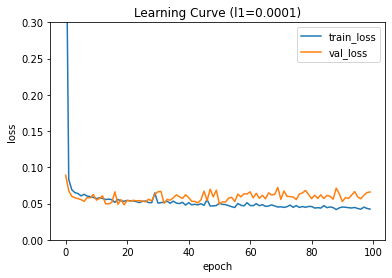

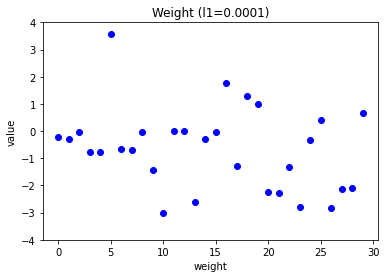

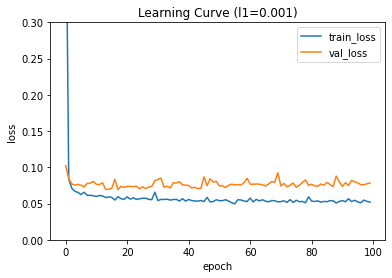

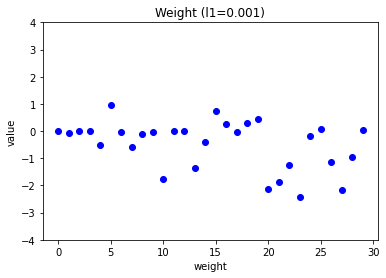

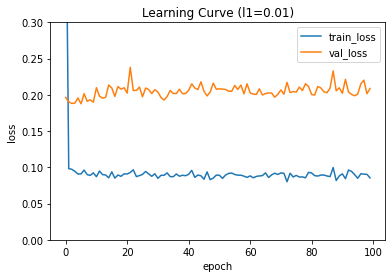

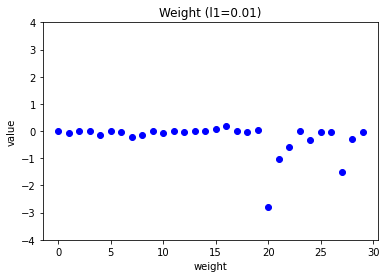

In [24]:
#cancer 데이터 세트에 L1 규제 적용

l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
  lyr = SingleLayer(l1=l1)
  lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve (l1={})'.format(l1))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'])
  plt.ylim(0, 0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.title('Weight (l1={})'.format(l1))
  plt.ylabel('value')
  plt.xlabel('weight')
  plt.ylim(-4, 4)
  plt.show()

In [25]:
#위에서 l1=0.001이 적절한 값으로 보이므로, 이를 이용해 모델의 성능 확인

layer5 = SingleLayer(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=20)
layer5.score(x_val_scaled, y_val)

0.989010989010989

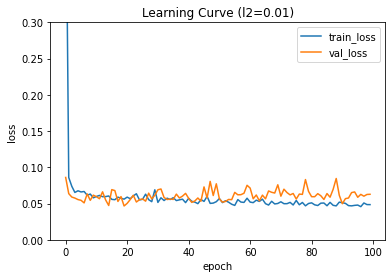

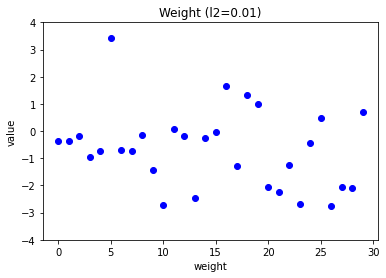

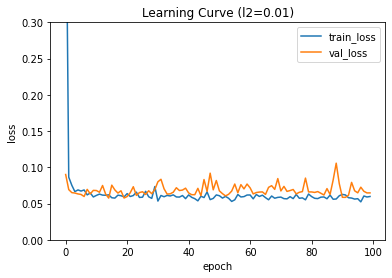

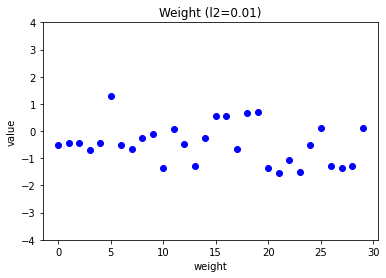

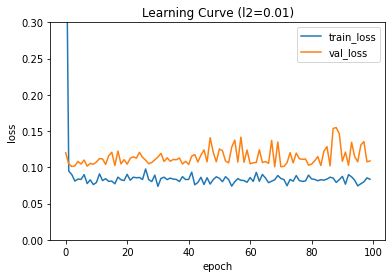

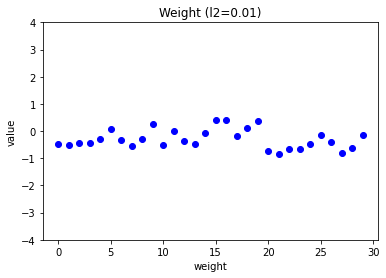

In [ ]:
#cancer 데이터 세트에 L2 규제 적용

l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
  lyr = SingleLayer(l2=l2)
  lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve (l2={})'.format(l1))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'])
  plt.ylim(0, 0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.title('Weight (l2={})'.format(l1))
  plt.ylabel('value')
  plt.xlabel('weight')
  plt.ylim(-4, 4)
  plt.show()

In [26]:
#L2 규제 성능 평가
#규제가 강해져도 L1규제 만큼 과소적합 심해지지 않음.

layer6 = SingleLayer(l2=0.01)
layer6.fit(x_train_scaled, y_train, epochs=50)
layer6.score(x_val_scaled, y_val)

0.989010989010989

In [27]:
#cancer 데이터 세트의 샘플 개수는 아주 적어서 L1 규제 적용한 모델과 L2 규제 적용한 모델의 성능은 큰 차이 없다.
#91개의 검증 샘플 중 89개의 샘플 올바르게 예측 #코드 수정했으니 다시 해볼것

np.sum(layer6.predict(x_val_scaled) == y_val)

90

In [28]:
#SGDClassifire에서 규제 사용하기
#여기서는 L2 규제 해본다.

sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

0.978021978021978

***05-4 교차 검증***

In [29]:
validation_scores = [] #각 폴드의 검증 점수 저장 이 값들의 평균이 최종 검증 점수

k = 10 #k-폴드 교차 검증
bins = len(x_train) // k #한 폴드에 들어갈 샘플의 개수 = 전체 훈련 세트 샘플 개수 / k

for i in range(k):
  start = i*bins
  end = (i+1)*bins
  val_fold = x_train_all[start:end]
  val_target = y_train_all[start:end]

  train_index = list(range(0, start))+list(range(end, len(x_train)))
  train_fold = x_train_all[train_index]
  train_target = y_train_all[train_index]

  train_mean = np.mean(train_fold, axis=0)
  train_std = np.std(train_fold, axis=0)
  train_fold_scaled = (train_fold - train_mean) / train_std
  val_fold_scaled = (val_fold - train_mean) / train_std

  lyr = SingleLayer(l2=0.01)
  lyr.fit(train_fold_scaled, train_target, epochs=50)
  score = lyr.score(val_fold_scaled, val_target)
  validation_scores.append(score)

print(np.mean(validation_scores))

0.9722222222222221


사이킷런 이용해 교차 검증

In [30]:
from sklearn.model_selection import cross_validate
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10) #cv=10은 10폴드를 뜻한다
print(np.mean(scores['test_score']))

#표준화 전처리를 하지 않아 낮다

0.850096618357488


In [31]:
#Pipeline 클래스 사용해 교차 검증 수행

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler(), sgd)
scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True) #마지막 매개변수 True로 하면 훈련 폴드의 점수도 얻을 수 있다.
print(np.mean(scores['test_score']))

#평균 검증 점수가 높아졌다.

0.9694202898550724


In [32]:
print(np.mean(scores['train_score']))

0.9875478561631581
